# Capstone Project - The Battle of the Neighborhoods (semana 2)
### Ciencia de datos Aplicada - Capstone

## Tabla de contenido
* [Introducnión: Problema del Negocio](#introduction)
* [Data](#data)
* [Metodología](#methodology)
* [Analisis](#analysis)
* [Resultados y Discusiones](#results)
* [Conclusiones](#conclusion)



## Introducción<a name="introduction"></a>

### Antecedentes<a name="Background"></a>

Últimamente, la comida asiática está ganando fuerza en Francia. Los restaurantes asiáticos suelen estar llenos de gente, especialmente en el área de París.

En el centro de París y en la 'pequeña corona', las baguettes vietnamitas y el té Bubble abren por todas partes y siempre están llenos a cualquier hora.

Este proyecto tiene como objetivo estimar la mejor ubicación para abrir un negocio de este tipo en la ciudad de Versalles, cerca de París.

Antes de lanzar cualquier restaurante, es importante saber si el negocio es una buena oportunidad. Para ello, este informe intentará recopilar datos sobre la localización de otros restaurantes, la competencia y la mejor localización.

Estos datos podrían usarse para un plan de negocios posterior.

### Problema <a name="Problem"></a>

Como el objetivo de esto es crear un plan de negocios al final, debemos asegurarnos de que los datos de la API sean correctos. También debemos verificar que el cliente pueda estar interesado en este negocio específico.

Para ello, además de la recopilación de datos, se realizará una encuesta en París y Versalles. Iré a las ciudades y verificaré a diferentes horas si los restaurantes funcionan, si las calles están llenas, etc., y qué restaurante principal funciona bien. Esta encuesta permitirá validar el análisis de datos aquí realizado.

### Interés  <a name="Interest"></a>

Este estudio puede ser utilizado por cualquier persona interesada en abrir un restaurante. O cualquier otro negocio.

Tal vez tendrán que modificar algunos datos. 

**Interes Personal**:

En realidad, tengo la intención de abrir este negocio, por lo que este estudio se hace con mucha seriedad, la encuesta también. Este estudio va a ser parte de un plan de negocios para entregar al banco con el fin de obtener una hipoteca para iniciar un negocio.

## Data <a name="data"></a>

Este trabajo está muy inspirado en la plantilla dada en el curso. Mantendré la idea de agrupar la ciudad por área y luego trazaré un mapa de calor para encontrar una mejor área.

Voy a cambiar algunos datos:
* País/Ciudad: Francia
* Meta: Abrir un restaurante/pequeña tienda para trabajadores entre semana y tal vez el sábado

Entonces, cruzaré datos de días hábiles y localizaciones.

Usaré la siguiente API:
* API de Foursquare: para encontrar restaurantes/lugares
* API de Google: geolocalización inversa

### Vecinos candidatos

Vamos a crear coordenadas de latitud y longitud para los centroides de nuestros vecindarios candidatos. Crearemos una cuadrícula de celdas que cubra nuestra área de interés que es de aprox. Kilómetros de 1,5 km centrados en el centro de la ciudad de **Versalles**.

Primero encontremos la latitud y longitud del centro de la ciudad de Versalles, utilizando una dirección específica y bien conocida y la API de geocodificación de Google Maps.

Consideraremos que la Prefectura es el centro de la ciudad, ya que hay muchas empresas alrededor.

#### Imports

In [ ]:
# This file contains all my ids for foursquare and google
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
CLIENT_ID = user_secrets.get_secret("CLIENT_ID")
CLIENT_SECRET = user_secrets.get_secret("CLIENT_SECRET")
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")


# Others imports:
from IPython.display import Image
import pickle
import json
import requests
import folium
import pandas as pd

# !pip install shapely
import shapely.geometry

# !pip install pyproj
import pyproj

import math

import warnings
warnings.simplefilter("ignore")



#### Basics functions

In [ ]:
def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]
    
address = 'Préfecture de Versailles, Versailles, Frances'
Versailles_center = get_coordinates(GOOGLE_API_KEY, address)
print('Coordinate of {}: {}'.format(address, Versailles_center))

Coordinate of Préfecture de Versailles, Versailles, Frances: [48.8027158, 2.1306535]


Now let's create a grid of area candidates, equaly spaced, centered around city center and within ~1.5km from Prefecture. Our neighborhoods will be defined as circular areas with a radius of 100 meters, so our neighborhood centers will be 200 meters apart.

To accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters).

In [ ]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Versailles center longitude={}, latitude={}'.format(Versailles_center[1], Versailles_center[0]))
x, y = lonlat_to_xy(Versailles_center[1], Versailles_center[0])
print('Versailles center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Versailles center longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
Versailles center longitude=2.1306535, latitude=48.8027158
Versailles center UTM X=-443902.44746775297, Y=5485922.887314021
Versailles center longitude=2.1306535000000024, latitude=48.8027158


#### City partitionning

Let's create a **hexagonal grid of cells**: we offset every other row, and adjust vertical row spacing so that **every cell center is equally distant from all it's neighbors**.

Let's visualize the data we have so far: city center location and candidate neighborhood centers:

In [ ]:
Versailles_center_x, Versailles_center_y = lonlat_to_xy(Versailles_center[1], Versailles_center[0]) # City center in Cartesian coordinates
nb_k = 10
radius = 100
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = Versailles_center_x - radius*10
x_step = radius*2
y_min = Versailles_center_y - radius*2 - (int(nb_k/k)*k*radius*2 - radius*10)/2
y_step = radius*2 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(nb_k/k)):
    y = y_min + i * y_step
    x_offset = radius if i%2==0 else 0
    for j in range(0, nb_k):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(Versailles_center_x, Versailles_center_y, x, y)
        if (distance_from_center <= 6001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)
            
map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
folium.Marker(Versailles_center, popup='Prefecture').add_to(map_versailles)
for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat, lon], radius=radius, color='blue', fill=False).add_to(map_versailles)
map_versailles

OK, we now have the coordinates of centers of neighborhoods/areas to be evaluated, equally spaced (distance from every point to it's neighbors is exactly the same) and within ~1.5km from Prefecture. 

Let's now use Google Maps API to get approximate addresses of those locations.

In [ ]:
def get_address(api_key, latitude, longitude, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&latlng={},{}'.format(api_key, latitude, longitude)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        address = results[0]['formatted_address']
        return address
    except:
        return None

addr = get_address(GOOGLE_API_KEY, Versailles_center[0], Versailles_center[1])
print('Reverse geocoding check')
print('-----------------------')
print('Address of [{}, {}] is: {}'.format(Versailles_center[0], Versailles_center[1], addr))

Reverse geocoding check
-----------------------
Address of [48.8027158, 2.1306535] is: 1 Avenue de l'Europe, 78000 Versailles, France


In [ ]:
addresses = []
compteur = 0

df_locations = pd.DataFrame()
loaded = False
try:
    with open('locations.pkl', 'rb') as f:
        df_locations = pickle.load(f)
    print('Location data loaded from pickle.')
    loaded = True
except:
    pass


if not loaded:
    print('Obtaining location addresses: ', end='')
    for lat, lon in zip(latitudes, longitudes):
        compteur = compteur + 1
        address = get_address(GOOGLE_API_KEY, lat, lon)
        if address is None:
            address = 'NO ADDRESS'
        address = address.replace(', France', '') # We don't need country part of address
        addresses.append(address)
        if compteur > 500:
            print("Urgency exit")
            break
    #     print(compteur)
        print(' .', end='')
    print(' done.')

Obtaining location addresses:  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


In [ ]:
if not loaded:
    addresses

Looking good. Let's now place all this into a Pandas dataframe.

In [ ]:

if not loaded:
    df_locations = pd.DataFrame({'Address': addresses,
                                 'Latitude': latitudes,
                                 'Longitude': longitudes,
                                 'X': xs,
                                 'Y': ys,
                                 'Distance from center': distances_from_center})

df_locations.head(10)

,Address,Latitude,Longitude,X,Y,Distance from center
0,"24bis Rue du Maréchal Joffre, 78000 Versailles",48.795635,2.120196,-444802.447468,5.485270e+06,1111.720843
1,"1 Rue Saint-Louis, 78000 Versailles",48.795937,2.122851,-444602.447468,5.485270e+06,957.038784
2,"62 Rue Royale, 78000 Versailles",48.796239,2.125506,-444402.447468,5.485270e+06,822.145506
3,"53 Rue d'Anjou, 78000 Versailles",48.796540,2.128161,-444202.447468,5.485270e+06,718.277964
4,"48 Avenue de Sceaux, 78000 Versailles",48.796842,2.130815,-444002.447468,5.485270e+06,660.244828
5,"31 Rue de Noailles, 78000 Versailles",48.797143,2.133470,-443802.447468,5.485270e+06,660.244828
6,"23 Rue Benjamin Franklin, 78000 Versailles",48.797445,2.136125,-443602.447468,5.485270e+06,718.277964
7,"11 Rue Edmé Frémy, 78000 Versailles",48.797746,2.138780,-443402.447468,5.485270e+06,822.145506
8,"68B Avenue de Paris, 78000 Versailles",48.798047,2.141435,-443202.447468,5.485270e+06,957.038784
9,"Jean Mermoz, 78000 Versailles",48.798348,2.144090,-443002.447468,5.485270e+06,1111.720843


...and let's now save/persist this data into local file.

In [ ]:
df_locations.to_pickle('./locations.pkl')    

## Methodology <a name="methodology"></a>

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on restaurants in each neighborhood.

We're interested in venues in 'food' category, but only the ones who can be competitors, this mean food truck, quick food, take away, healthy, not restaurant taking too long.

**We will also list all companies and university to evaluate the customer pool**.

Foursquare credentials are defined in hidden cell bellow.

In [ ]:
foursquare_client_id = CLIENT_ID
foursquare_client_secret = CLIENT_SECRET

In [ ]:
# Category IDs corresponding to Italian restaurants were taken from Foursquare web site 
# (https://developer.foursquare.com/docs/resources/categories):

food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues

# We will add some asian categories, and also take away food, and healthy food. These category are the one that
# may be competitor
asian_restaurant_categories = ['4bf58dd8d48988d142941735','4bf58dd8d48988d145941735', '4bf58dd8d48988d111941735',
                                '4bf58dd8d48988d1d2941735', '4bf58dd8d48988d1d1941735', '4bf58dd8d48988d14a941735',
                              '56aa371be4b08b9a8d57350b', '4bf58dd8d48988d1cb941735', '4bf58dd8d48988d1e0931735',
                              '4bf58dd8d48988d16c941735', '4bf58dd8d48988d16f941735', '5283c7b4e4b094cb91ec88d7',
                              '4bf58dd8d48988d1bd941735', '4bf58dd8d48988d1c5941735', '4bf58dd8d48988d1c7941735']

def is_restaurant(categories, specific_filter=None):
    restaurant_words = ['Restaurant', 'restaurant', 'diner', 'taverna', 'steakhouse', 'Brasserie', 'Creperie', 'Café',
                       'Truck', 'Sandwich', 'Pizza']
    restaurant = False
    specific = False
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in restaurant_words:
            if r in category_name:
                restaurant = True
        if 'fast food' in category_name:
            restaurant = False
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
            restaurant = True
    return restaurant, specific

def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def format_address(location):
    address = ', '.join(location['formattedAddress'])
    return address

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    version = '20180724'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues

In [ ]:
# Let's now go over our neighborhood locations and get nearby restaurants; we'll also maintain 
# a dictionary of all found restaurants and all found italian restaurants

def get_restaurants(lats, lons):
    from tqdm.autonotebook import tqdm
    tqdm.pandas()
    restaurants = {}
    asian_restaurants = {}
    location_restaurants = []

    print('Obtaining venues around candidate locations:', end='')
    pbar = tqdm(total=len(lats))
    for lat, lon in zip(lats, lons):
        # Using radius=350 to meke sure we have overlaps/full coverage so we don't miss any restaurant (we're using dictionaries to remove any duplicates resulting from area overlaps)
        venues = get_venues_near_location(lat, lon, food_category, foursquare_client_id, 
                                          foursquare_client_secret, radius=350, limit=100)
#         with open('1. venues.txt', 'w') as outfile:
#             json.dump(venues, outfile)
        area_restaurants = []
#         print(venues)
        
        for venue in venues:            
#             with open('2. venue.txt', 'w') as outfile:
#                 json.dump(venue, outfile)
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_res, is_asian = is_restaurant(venue_categories, specific_filter=asian_restaurant_categories)
            if is_res:
                x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
                restaurant = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, 
                              venue_distance, is_asian, x, y)
#                 print("\n" + str(restaurant))
                if venue_distance<=100:
                    area_restaurants.append(restaurant)
                restaurants[venue_id] = restaurant
                if is_asian:
                    asian_restaurants[venue_id] = restaurant
        pbar.update(1)        
        
        location_restaurants.append(area_restaurants)
#         print(' .', end='')
    pbar.close()
#     print(' done.')
    return restaurants, asian_restaurants, location_restaurants

# Try to load from local file system in case we did this before
restaurants = {}
asian_restaurants = {}
location_restaurants = []
loaded = False
try:
    with open('restaurants_350.pkl', 'rb') as f:
        restaurants = pickle.load(f)
    with open('asian_restaurants_350.pkl', 'rb') as f:
        asian_restaurants = pickle.load(f)
    with open('location_restaurants_350.pkl', 'rb') as f:
        location_restaurants = pickle.load(f)
    print('Restaurant data loaded.')
    loaded = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    restaurants, asian_restaurants, location_restaurants = get_restaurants(latitudes, longitudes)
    
    # Let's persists this in local file system
    with open('restaurants_350.pkl', 'wb') as f:
        pickle.dump(restaurants, f)
    with open('asian_restaurants_350.pkl', 'wb') as f:
        pickle.dump(asian_restaurants, f)
    with open('location_restaurants_350.pkl', 'wb') as f:
        pickle.dump(location_restaurants, f)
        

Obtaining venues around candidate locations:

In [ ]:
import numpy as np

print('Total number of restaurants:', len(restaurants))
print('Total number of Asian restaurants:', len(asian_restaurants))
print('Percentage of Asian restaurants: {:.2f}%'.format(len(asian_restaurants) / len(restaurants) * 100))
print('Average number of restaurants in neighborhood:', np.array([len(r) for r in location_restaurants]).mean())

Total number of restaurants: 86
Total number of Asian restaurants: 17
Percentage of Asian restaurants: 19.77%
Average number of restaurants in neighborhood: 0.5


#### Restaurants visualization

Let's now see all the collected restaurants in our area of interest on map, and let's also show Asian restaurants in different color.

In [ ]:
map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
folium.Marker(Versailles_center, popup='Prefecture').add_to(map_versailles)
for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_asian = res[6]
    color = 'red' if is_asian else 'blue'
    label = '{}'.format(res[1])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color,                         
                        popup=label, fill_opacity=1, parse_html=False).add_to(map_versailles)
map_versailles

So, on this map we can see all potential competitors, take away restaurant, healthy restaurant. Asian restaurant are in red.

No we need to analyse companies/university localisation and cluster and cross both analysis.

We need to remember that the target are worker wanting to buy healthy fast food for breakfast and lunch, we don't aim the evening. Also, another target can be universities.

#### Universities visualization

In [ ]:
# 'Root' category for all universities venues
univ_category = ['4d4b7105d754a06372d81259']

def get_meta_venues(lats, lons, meta_category):
    from tqdm.autonotebook import tqdm
    tqdm.pandas()
    meta_venues = {}
    neighborhoods_venues = []

#     print('Obtaining venues around candidate locations:', end='')
    pbar = tqdm(total=len(lats), desc = 'Obtaining venues', unit= ' coord')
    for lat, lon in zip(lats, lons):
        # Using radius=350 to meke sure we have overlaps/full coverage so we don't miss any restaurant (we're using dictionaries to remove any duplicates resulting from area overlaps)
        area_meta_venues = []
        for i, category in enumerate(meta_category):
            venues = get_venues_near_location(lat, lon, category, foursquare_client_id, 
                                              foursquare_client_secret, radius=350, limit=100)
            for venue in venues:
                venue_id = venue[0]
                venue_name = venue[1]
                venue_categories = venue[2]
                venue_latlon = venue[3]
                venue_address = venue[4]
                venue_distance = venue[5]

                x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
                restaurant = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], 
                              venue_address, venue_distance, is_asian, x, y)
                if venue_distance<=100:
                    area_meta_venues.append(restaurant)
                meta_venues[venue_id] = restaurant

            neighborhoods_venues.append(area_meta_venues)
#         print(' .', end='')
        pbar.update(1)
    pbar.close()
#     print(' done.')
    return meta_venues, neighborhoods_venues



# plantage = plantage # Just to make sure we won't go after this point

# Try to load from local file system in case we did this before
meta_univ = {}
neighborhoods_univ = []
loaded = False
try:
    with open('meta_univ_350.pkl', 'rb') as f:
        meta_univ = pickle.load(f)
    with open('neighborhoods_univ_350.pkl', 'rb') as f:
        neighborhoods_univ = pickle.load(f)
    print('Universities data loaded.')
    loaded = True
except:
    pass

if not loaded:
    meta_univ, neighborhoods_univ = get_meta_venues(latitudes, longitudes, univ_category)
    
    # Let's persists this in local file system
    with open('meta_univ_350.pkl', 'wb') as f:
        pickle.dump(meta_univ, f)
    with open('neighborhoods_univ_350.pkl', 'wb') as f:
        pickle.dump(neighborhoods_univ, f)
        
print('Total number of universities:', len(meta_univ))
print('Average number of universities in neighborhood:', np.array([len(r) for r in neighborhoods_univ]).mean())

map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
folium.Marker(Versailles_center, popup='Prefecture').add_to(map_versailles)
for res in meta_univ.values():
    lat = res[2]; lon = res[3]
    is_univ = res[6]
    color = 'blue' 
    label = '{}'.format(res[1])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color,                         
                        popup=label, fill_opacity=1, parse_html=False).add_to(map_versailles)
map_versailles


Total number of universities: 32
Average number of universities in neighborhood: 0.18181818181818182


#### Companies visualization

In [ ]:
# 'Root' category for all companies venues
companies_category = ['4d4b7105d754a06375d81259', '4d4b7105d754a06378d81259', '4d4b7105d754a06379d81259',
                     '4d4b7104d754a06370d81259']

# Try to load from local file system in case we did this before
meta_company = {}
neighborhoods_company = []
loaded = False
try:
    with open('meta_company_350.pkl', 'rb') as f:
        meta_company = pickle.load(f)
    with open('neighborhoods_company_350.pkl', 'rb') as f:
        neighborhoods_company = pickle.load(f)
    print('Companies data loaded.')
    loaded = True
except:
    pass

if not loaded:
    meta_company, neighborhoods_company = get_meta_venues(latitudes, longitudes, companies_category)
    
    # Let's persists this in local file system
    with open('meta_company_350.pkl', 'wb') as f:
        pickle.dump(meta_company, f)
    with open('neighborhoods_company_350.pkl', 'wb') as f:
        pickle.dump(neighborhoods_company, f)
        
print('Total number of companies:', len(meta_company))
print('Average number of companies in neighborhood:', np.array([len(r) for r in neighborhoods_company]).mean())

map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
folium.Marker(Versailles_center, popup='Prefecture').add_to(map_versailles)
for res in meta_company.values():
    lat = res[2]; lon = res[3]
    is_company = res[6]
    color = 'red'
    label = '{}'.format(res[1])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color,                         
                        popup=label, fill_opacity=1, parse_html=False).add_to(map_versailles)
map_versailles


Total number of companies: 335
Average number of companies in neighborhood: 2.209090909090909


### Global map of worker/students versus Restaurants

In [ ]:
map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
folium.Marker(Versailles_center, popup='Prefecture').add_to(map_versailles)
for res in meta_company.values():
    lat = res[2]; lon = res[3]
    color = 'green'
    label = '{}'.format(res[1])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color,                         
                        popup=label, fill_opacity=1, parse_html=False).add_to(map_versailles)
for res in meta_univ.values():
    lat = res[2]; lon = res[3]
    color = 'yellow'
    label = '{}'.format(res[1])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color,                         
                        popup=label, fill_opacity=1, parse_html=False).add_to(map_versailles)
for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_asian = res[6]
    color = 'red' if is_asian else 'blue'
    label = '{}'.format(res[1])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color,                         
                        popup=label, fill_opacity=1, parse_html=False).add_to(map_versailles)
map_versailles

Good, we have a map with the big companies and universities, we can then already see main areas with potential customers.

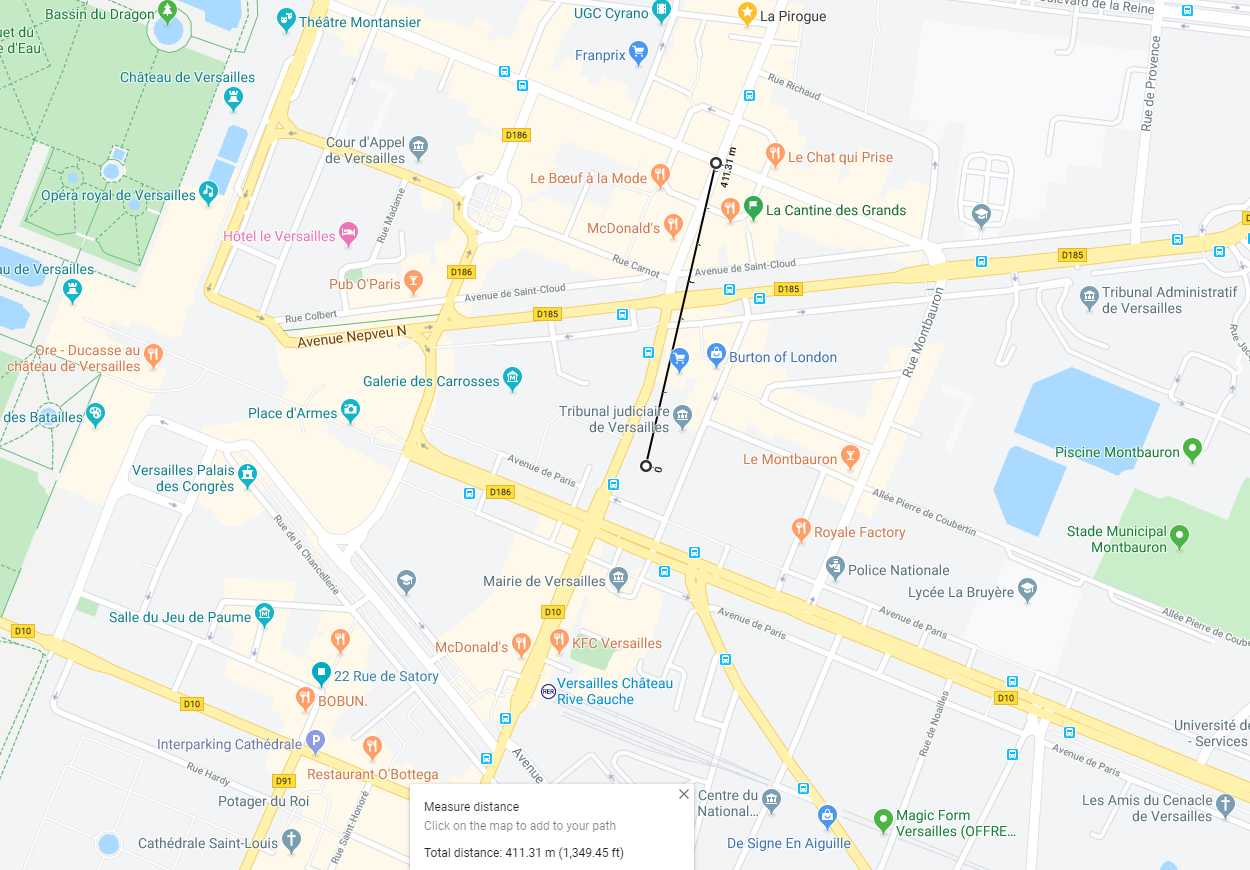

In [ ]:
Image("../input/versailles_size.PNG")

After visualization of data we can conclude:
* Competitors are scattered around the city, but there are just a few real competitors (actually only one is doing Vietnamese baguette and Bubble tea in Versailles)
* Very close to the prefecture there are just a few companies (in the 100/200m radius), they are 300m south and north.

We will now focus on spotting worker area more than competitors, we will try do determine where are clusters more of the worker.

In order to do that, we will use the **k mean clustering method**.

#### Creation and visualization of customer group:

In [ ]:
# 'Root' category for all companies venues
customer_category = ['4d4b7105d754a06375d81259', '4d4b7105d754a06378d81259', '4d4b7105d754a06379d81259',
                     '4d4b7104d754a06370d81259', '4d4b7105d754a06372d81259']

# Try to load from local file system in case we did this before
meta_customers = []
neighborhoods_customers = []
loaded = False
try:
    with open('meta_customers_350.pkl', 'rb') as f:
        meta_customers = pickle.load(f)
    with open('neighborhoods_customers_350.pkl', 'rb') as f:
        neighborhoods_customers = pickle.load(f)
    print('Companies data loaded.')
    loaded = True
except:
    pass

if not loaded:
    from tqdm.autonotebook import tqdm
    pbar1 = tqdm(total=len(customer_category), desc = 'Cycling categories', unit= ' categories')
    for category in customer_category:
        meta_customer, neighborhoods_customer = get_meta_venues(latitudes, longitudes, [category])
        meta_customers.append(meta_customer)
        neighborhoods_customers.append(neighborhoods_customer)
        pbar1.update(1)
    pbar1.close()
    
    # Let's persists this in local file system
    with open('meta_customers_350.pkl', 'wb') as f:
        pickle.dump(meta_customers, f)
    with open('neighborhoods_customers_350.pkl', 'wb') as f:
        pickle.dump(neighborhoods_customers, f)
        
print('Total number of customers:', len(meta_customers))
print('Average number of customers in neighborhood:', np.array([len(r) for r in neighborhoods_customers]).mean())

map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
folium.Marker(Versailles_center, popup='Prefecture').add_to(map_versailles)
for meta_customer in meta_customers:
    for res in meta_customer.values():
        lat = res[2]; lon = res[3]
        color = 'red'
        label = '{}'.format(res[1])
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color,                         
                            popup=label, fill_opacity=1, parse_html=False).add_to(map_versailles)
map_versailles



Total number of customers: 5
Average number of customers in neighborhood: 110.0


## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of business in every area candidate**:

In [ ]:
counts = []
for i, neighborhoods_customer in enumerate(neighborhoods_customers):
    counts.append([len(res) for res in neighborhoods_customers[i]])
final_count= []
len(counts[0])
for m in range(len(counts[0])):
    final_count.append(0)
    for n in range(len(counts)):
        final_count[m] = final_count[m] + counts[n][m]
len(final_count)

110

In [ ]:
# location_customers_count = [len(res) for res in neighborhoods_customers]
counts = []
for i, neighborhoods_customer in enumerate(neighborhoods_customers):
    counts.append([len(res) for res in neighborhoods_customers[i]])
location_customers_count= []
len(counts[0])
for m in range(len(counts[0])):
    location_customers_count.append(0)
    for n in range(len(counts)):
        location_customers_count[m] = location_customers_count[m] + counts[n][m]

df_locations['Customers in area'] = location_customers_count

print('Average number of customers in every area with radius=100m:', np.array(location_customers_count).mean())

df_locations.head(5)

Average number of customers in every area with radius=100m: 2.4454545454545453


,Address,Latitude,Longitude,X,Y,Distance from center,Customers in area
0,"24bis Rue du Maréchal Joffre, 78000 Versailles",48.795635,2.120196,-444802.447468,5.485270e+06,1111.720843,3
1,"1 Rue Saint-Louis, 78000 Versailles",48.795937,2.122851,-444602.447468,5.485270e+06,957.038784,0
2,"62 Rue Royale, 78000 Versailles",48.796239,2.125506,-444402.447468,5.485270e+06,822.145506,7
3,"53 Rue d'Anjou, 78000 Versailles",48.796540,2.128161,-444202.447468,5.485270e+06,718.277964,2
4,"48 Avenue de Sceaux, 78000 Versailles",48.796842,2.130815,-444002.447468,5.485270e+06,660.244828,0


#### 10 first areas

In [ ]:
df_locations.sort_values(by='Customers in area', ascending=False).head(10)

,Address,Latitude,Longitude,X,Y,Distance from center,Customers in area
13,"14 Rue Royale, 78000 Versailles",48.797908,2.126438,-444302.447468,5.485443e+06,624.376715,19
65,"4 Rue au Pain, 78000 Versailles",48.806257,2.131099,-443802.447468,5.486309e+06,399.326338,17
76,"3 Impasse Duplessis, 78000 Versailles",48.807927,2.132031,-443702.447468,5.486483e+06,594.461582,15
57,"48 Avenue de Saint-Cloud, 78000 Versailles",48.805190,2.135477,-443502.447468,5.486136e+06,453.363514,13
64,"15 Rue Carnot, 78000 Versailles",48.805955,2.128443,-444002.447468,5.486309e+06,399.326338,13
75,"37 Rue de la Paroisse, 78000 Versailles",48.807625,2.129376,-443902.447468,5.486483e+06,559.807621,13
56,"Europe Saint-Cloud, 78000 Versailles",48.804889,2.132822,-443702.447468,5.486136e+06,292.469615,12
66,"63 Rue de la Paroisse, 78000 Versailles",48.806558,2.133754,-443602.447468,5.486309e+06,489.348060,10
6,"23 Rue Benjamin Franklin, 78000 Versailles",48.797445,2.136125,-443602.447468,5.485270e+06,718.277964,9
83,"19 Rue des Réservoirs, 78000 Versailles",48.808692,2.124997,-444202.447468,5.486656e+06,792.027538,8


The mains areas are in the north of prefecture, usualy around 400/500m away, it's not a big surprise.

In [ ]:
restaurant_latlons = [[res[2], res[3]] for res in restaurants.values()]

customers_latlons = []
for meta_customer in meta_customers:
    customers_latlons.append([[res[2], res[3]] for res in meta_customer.values()])

In [ ]:
from folium import plugins
from folium.plugins import HeatMap

map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
folium.TileLayer('cartodbpositron').add_to(map_versailles) #cartodbpositron cartodbdark_matter
for customers_latlon in customers_latlons:
    HeatMap(customers_latlon).add_to(map_versailles)
# folium.Marker(Versailles_center).add_to(map_versailles)
folium.Circle(Versailles_center, radius=100, fill=False, color='white').add_to(map_versailles)
folium.Circle(Versailles_center, radius=300, fill=False, color='white').add_to(map_versailles)
folium.Circle(Versailles_center, radius=500, fill=False, color='white').add_to(map_versailles)
map_versailles

We can clearly identify **two big cluster, on north, on south**. 

Let's create another heatmap map showing **heatmap/density of restaurants**.

In [ ]:
map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
folium.TileLayer('cartodbpositron').add_to(map_versailles) #cartodbpositron cartodbdark_matter
HeatMap(restaurant_latlons).add_to(map_versailles)
folium.Marker(Versailles_center, popup='Prefecture').add_to(map_versailles)
folium.Marker([48.804394, 2.131718], popup='La boite a Bobun',
    icon=folium.Icon(color='red', icon='info-sign')).add_to(map_versailles)
folium.Circle(Versailles_center, radius=100, fill=False, color='white').add_to(map_versailles)
folium.Circle(Versailles_center, radius=300, fill=False, color='white').add_to(map_versailles)
folium.Circle(Versailles_center, radius=500, fill=False, color='white').add_to(map_versailles)
map_versailles

As expected, the restaurants are also in this area, but if we look at the first map, we can see that **we almost have no competitors in this area**.

The only competitor is indicated in red, and actually they are **not making bubble tea**, and the sandwitch are not real vietnamese style.

#### Zoom north west

In [ ]:
from folium import plugins
from folium.plugins import HeatMap

map_versailles = folium.Map(location=[48.806812, 2.131194], zoom_start=16)
folium.TileLayer('cartodbpositron').add_to(map_versailles) #cartodbpositron cartodbdark_matter
for customers_latlon in customers_latlons:
    HeatMap(customers_latlon).add_to(map_versailles)
# folium.Marker(Versailles_center).add_to(map_versailles)
folium.Marker([48.804394, 2.131718], popup='La boite a Bobun',
    icon=folium.Icon(color='red', icon='info-sign')).add_to(map_versailles)
folium.Marker([48.806350, 2.131048], popup='Good spot',
    icon=folium.Icon(color='green')).add_to(map_versailles)
folium.Circle([48.806350, 2.131048], radius=300, color='white', fill=True, fill_opacity=0.4).add_to(map_versailles)
map_versailles

In [ ]:
map_versailles = folium.Map(location=[48.806812, 2.131194], zoom_start=16)
folium.TileLayer('cartodbpositron').add_to(map_versailles) #cartodbpositron cartodbdark_matter
HeatMap(restaurant_latlons).add_to(map_versailles)
folium.Marker(Versailles_center, popup='Prefecture').add_to(map_versailles)
folium.Marker([48.804394, 2.131718], popup='La boite a Bobun',
    icon=folium.Icon(color='red', icon='info-sign')).add_to(map_versailles)
folium.Marker([48.806350, 2.131048], popup='Good spot',
    icon=folium.Icon(color='green')).add_to(map_versailles)
folium.Circle([48.806350, 2.131048], radius=300, color='white', fill=True, fill_opacity=0.4).add_to(map_versailles)
map_versailles

We can clearly identify here an area with a lot of customer and few competitors >>> See the **green marker**.

The white circle indicate an area 300m wide. We can see that a lot of worker are inside, and the main competitor is not in the center.

### K mean clustering

Let's do the kmean clustering to see what will be the result.

In [ ]:
# We plot the area where we'll search for good localisation
roi_x_min = Versailles_center_x -1000
roi_y_max = Versailles_center_y
roi_width = 1500
roi_height = 1500
roi_center_x = roi_x_min
roi_center_y = roi_y_max
roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
roi_center = [roi_center_lat, roi_center_lon]

map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
for customers_latlon in customers_latlons:
    HeatMap(customers_latlon).add_to(map_versailles)
folium.Marker(Versailles_center).add_to(map_versailles)
folium.Circle(Versailles_center, radius=700, color='white', fill=True, fill_opacity=0.4).add_to(map_versailles)
map_versailles

In [ ]:
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
nb_k = 20 #51 a la base
x_step = 100
y_step = 100 * k 
roi_y_min = roi_center_y - 700

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
for i in range(0, int(nb_k/k)):
    y = roi_y_min + i * y_step
    x_offset = (nb_k-1) if i%2==0 else 0
    for j in range(0, 51):
        x = roi_x_min + j * x_step + x_offset
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 2501):
            lon, lat = xy_to_lonlat(x, y)
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), 'candidate neighborhood centers generated.')

563 candidate neighborhood centers generated.


OK. Now let's calculate two most important things for each location candidate: **number of restaurants in vicinity** (we'll use radius of **150 meters**) and **number of customers**.

In [ ]:
def count_restaurants_nearby(x, y, restaurants, radius=150):    
    count = 0
    for res in restaurants.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=radius:
            count += 1
    return count

def find_nearest_restaurant(x, y, restaurants):
    d_min = 100000
    for res in restaurants.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=d_min:
            d_min = d
    return d_min

def count_customers_nearby(x, y, customers, radius=150):    
    count = 0
    for meta_customer in meta_customers:
        for res in meta_customer.values():
            res_x = res[7]; res_y = res[8]
            d = calc_xy_distance(x, y, res_x, res_y)
            if d<=radius:
                count += 1
    return count

roi_restaurant_counts = []
roi_asian_restaurants = []
roi_customer = []

print('Generating data on location candidates... ', end='')
for x, y in zip(roi_xs, roi_ys):
    count = count_restaurants_nearby(x, y, restaurants, radius=100)
    roi_restaurant_counts.append(count)
    
    distance = find_nearest_restaurant(x, y, asian_restaurants)
    roi_asian_restaurants.append(distance)
    
    custom = count_customers_nearby(x, y, meta_customers)
    roi_customer.append(custom)
print('done.')


Generating data on location candidates... done.


In [ ]:
# Let's put this into dataframe
df_roi_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys,
                                 'Restaurants nearby':roi_restaurant_counts,
                                 'Distance to Asian restaurant':roi_asian_restaurants,
                                 'Customers':roi_customer})

df_roi_locations.sort_values(by='Customers', ascending=False).head(10)
# df_roi_locations.head()

,Latitude,Longitude,X,Y,Restaurants nearby,Distance to Asian restaurant,Customers
334,48.806450,2.129681,-443902.447468,5.486349e+06,1,188.687521,41
359,48.807238,2.129736,-443883.447468,5.486435e+06,0,115.761201,40
335,48.806601,2.131009,-443802.447468,5.486349e+06,4,124.898992,40
360,48.807389,2.131064,-443783.447468,5.486435e+06,2,122.347533,35
336,48.806752,2.132337,-443702.447468,5.486349e+06,10,86.438542,31
333,48.806299,2.128354,-444002.447468,5.486349e+06,0,184.741199,30
361,48.807540,2.132391,-443683.447468,5.486435e+06,4,36.782293,30
310,48.805870,2.131459,-443783.447468,5.486262e+06,12,71.643837,29
80,48.798252,2.126348,-444302.447468,5.485483e+06,0,256.697128,28
385,48.808120,2.130614,-443802.447468,5.486522e+06,1,139.656859,27


OK. Let us now **filter** those locations: we're interested only in **locations with no more than two restaurants in radius of 250 meters**, and **no asian restaurants in radius of 100 meters**, and **more than 10 customers**.

In [ ]:
good_res_count = np.array((df_roi_locations['Restaurants nearby']<=2))
print('Locations with no more than two restaurants nearby:', good_res_count.sum())

good_asi_distance = np.array(df_roi_locations['Distance to Asian restaurant']>=100)
print('Locations with no Asian restaurants within 400m:', good_asi_distance.sum())

good_custmer_count = np.array(df_roi_locations['Customers']>=10)
print('Locations with more than 10 customers:', good_custmer_count.sum())

good_locations = np.logical_and(good_custmer_count, good_res_count, good_asi_distance)
print('Locations with both conditions met:', good_locations.sum())

df_good_locations = df_roi_locations[good_locations]


Locations with no more than two restaurants nearby: 536
Locations with no Asian restaurants within 400m: 513
Locations with more than 10 customers: 92
Locations with both conditions met: 72


Let's see how this looks on a map.

In [ ]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
folium.TileLayer('cartodbpositron').add_to(map_versailles)
HeatMap(restaurant_latlons).add_to(map_versailles)
folium.Circle(Versailles_center, radius=700, color='white', fill=True, fill_opacity=0.6).add_to(map_versailles)
folium.Marker(Versailles_center).add_to(map_versailles)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, 
                        fill_color='blue', fill_opacity=1).add_to(map_versailles) 
map_versailles

We can identify two mains areas, one south, the other one north as expected.

Let's see heatmap:

In [ ]:
map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
HeatMap(good_locations, radius=35).add_to(map_versailles)
folium.Marker(Versailles_center).add_to(map_versailles)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, 
                        fill_color='blue', fill_opacity=1).add_to(map_versailles)
map_versailles

Looking good. What we have now is a clear indication of zones with low number of restaurants in vicinity, and *no* Asian restaurants at all nearby, and good numbers of customers.

Let us now **cluster** those locations to create **centers of zones containing good locations**. Those zones, their centers and addresses will be the final result of our analysis. 

In [ ]:
from sklearn.cluster import KMeans

number_of_clusters = 15

good_xys = df_good_locations[['X', 'Y']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
folium.TileLayer('cartodbpositron').add_to(map_versailles)
for customers_latlon in customers_latlons:
    HeatMap(customers_latlon).add_to(map_versailles)
folium.Circle(Versailles_center, radius=700, color='white', fill=True, fill_opacity=0.4).add_to(map_versailles)
folium.Marker(Versailles_center).add_to(map_versailles)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=80, color='green', fill=True, fill_opacity=0.25).add_to(map_versailles) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', 
                        fill_opacity=1).add_to(map_versailles)
map_versailles

Not bad - our clusters represent groupings of most of the candidate locations and cluster centers are placed nicely in the middle of the zones 'rich' with location candidates.

Addresses of those cluster centers will be a good starting point for exploring the neighborhoods to find the best possible location based on neighborhood specifics.

Let's see those zones on a city map without heatmap, using shaded areas to indicate our clusters:

In [ ]:
map_versailles = folium.Map(location=Versailles_center, zoom_start=15)
folium.Marker(Versailles_center).add_to(map_versailles)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#00000000', fill=True, fill_color='#0066ff', 
                  fill_opacity=0.07).add_to(map_versailles)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', 
                        fill_opacity=1).add_to(map_versailles)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=80, color='green', fill=False).add_to(map_versailles) 
map_versailles

Let's zoom in on candidate areas in **north, on the Marché Notre Dame**:

In [ ]:
map_versailles = folium.Map(location=[48.806620, 2.132041], zoom_start=16)
folium.Marker(Versailles_center).add_to(map_versailles)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=60, color='green', fill=False).add_to(map_versailles) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', 
                  fill_opacity=0.07).add_to(map_versailles)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', 
                        fill_opacity=1).add_to(map_versailles)
map_versailles

Finaly, let's **reverse geocode those candidate area centers to get the addresses** which can be presented to stakeholders.

In [ ]:
candidate_area_addresses = []
print('==============================================================')
print('Addresses of centers of areas recommended for further analysis')
print('==============================================================\n')
for lon, lat in cluster_centers:
    addr = get_address(GOOGLE_API_KEY, lat, lon).replace(', France', '')
    candidate_area_addresses.append(addr)    
    x, y = lonlat_to_xy(lon, lat)
    d = calc_xy_distance(x, y, Versailles_center_x, Versailles_center_y)
    print('{}{} => {:.1f}km from Prefecture'.format(addr, ' '*(50-len(addr)), d/1000))
    

Addresses of centers of areas recommended for further analysis



AttributeError: 'NoneType' object has no attribute 'replace'

## Results and Discussion <a name="results"></a>

This analysis shows that we must consider other criterias than just number of restaurant.

Versailles is a little city, so the concentration of restaurant is quite high, in this analysis I tried to corrolate the number of restaurant and quantity of potential customer.

In opposit to  what I was thinking, the Prefecture area is not very crowded, mainly because building are big (French old style building, full of empty space and big garden).

Also, I was able to discover that there are not a lot of competitor on this business area, which is very good.

15 good potential places are foud, I personnaly think that the one in the north is better.

We must just take care of one thing, I thing the api didn't return all data, we are missing a lot of companies, the map is still good, and the result can be trusted, but we should cross check data with other data source.

In order to be more accurate, it could be possible to give a weight to customers for example, a university with 1000 student would then weight more than a hair cut company with two employees.

## Conclusion <a name="conclusion"></a>

This project can be reused for other cities, just think about changing clustering size to adapt to your city.

Also, I have created/modify a huge quantity of function in order to adapt. 

It's very far from being perfect, a lot of work can be done, other source of data can be found, but in the end the result seams to correlate with the real world, when we know the city, the area predicted seams correct.